# Данные

В исследовании используются данные с рейтингами управляющих организаций города Москвы за 2019, 2020 и 2021 год.

Данные взяты с сайта https://data-new.mos.ru/.

Описание данных с портала открытых данных Правительства Москвы:

"Мосжилинспекцией ведется анализ работы управляющих организаций города Москвы. По результатам анализа ежегодно составляется рейтинг управляющих организаций. Организации оцениваются по трём основным показателям: количество нарушений, уровень надежности и степень удовлетворения населения. Рейтинг управляющих организаций призван повысить прозрачность и качество оказания услуг в сфере управления многоквартирным жилым фондом. Рейтинг позволяет жителям получать объективную информацию о качестве работы их управляющих организаций, видеть, какое место она занимает среди других управляющих организаций, работающих на территории города Москвы. Это помогает поддерживать здоровую конкуренцию между участниками этого рынка, а жителям - принимать правильные решения, к примеру, о замене неэффективно работающих управляющих организаций на более эффективные."

# Какие данные представлены?

- Локальный идентификатор каждой УО
- Наименование управляющей организации
- ИНН организации
- Административный округ, в котром работает организация
- Количество домов в управлении организации
- Площадь домов в управлении организации (кв. м)
- Уровень удовлетворенности населения
- Уровень надежности УО
- Уровень нарушений в работе УО
- Суммарное количество баллов - Уровень удовлетворенности населения * 0,4 + Уровень надежности УО * 0,2 + Уровень нарушений в работе УО * 0,4
- Итоговый рейтинг
- global_id - глобальный идентификатор УО

# Исследуемые вопросы

1. В каких административных округах находится наибольшее количество компаний? Происходят ли изменения от года к году?

2. Какие компании являются самыми крупными? В каких округах они ведут работу?

3. Являются ли изменения в оценках компаний статистически значимыми?

4. Как менялись оценки 10 самых крупных компаний?

# 1. Предобработка данных

In [4]:
# Загрузка нужных библиотек
import numpy as np
import pandas as pd
import re

from IPython.display import Image, display

from scipy.stats import shapiro
import scipy.stats as stats

from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [5]:
# Загрузка данных
rate_2019 = pd.read_excel('data/rating_2019.xlsx')
rate_2020 = pd.read_excel('data/rating_2020.xlsx')
rate_2021 = pd.read_excel('data/rating_2021.xlsx')

## 1.1. Рейтинг компаний за 2019 год

In [6]:
print(rate_2019.shape)
rate_2019.head()

(562, 12)


,Локальный идентификатор,Наименование управляющей организации,ИНН,Административный округ,Количество домов в управлении,Площадь домов в управлении (кв. м),Уровень удовлетворенности населения,Уровень надежности УО,Уровень нарушений в работе УО,"Суммарное количество баллов Z1*0,4+Z2*0,2+Z3*0,4",Итоговый рейтинг,global_id
0,1,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ «УПРА...,9706004109,Центральный административный округ,1,5267,ScoresOfAppeals:100\nCoefficientValue:1.1\nSco...,ScoresByStandart:100\nScoresSumZ2:100\nInterme...,DetectedViolationsScores:100\nPenaltyScores:10...,104.00,1,1075032366
1,93,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ «КОМП...,7716196822,Северо-Восточный административный округ,32,353030,ScoresOfAppeals:99.11\nCoefficientValue:1\nSco...,ScoresByStandart:100\nScoresSumZ2:100\nInterme...,DetectedViolationsScores:99.69\nPenaltyScores:...,101.96,93,1075032367
2,26,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ «КОНОК»,7709448067,Центральный административный округ,1,8011,ScoresOfAppeals:100\nCoefficientValue:1.1\nSco...,ScoresByStandart:100\nScoresSumZ2:100\nInterme...,DetectedViolationsScores:99.81\nPenaltyScores:...,103.19,26,1075032368
3,27,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ «УПРА...,7702660770,Центральный административный округ,8,41964,ScoresOfAppeals:98.52\nCoefficientValue:1.1\nS...,ScoresByStandart:100\nScoresSumZ2:100\nInterme...,DetectedViolationsScores:99.56\nPenaltyScores:...,103.13,27,1075032369
4,2,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ «АВРО...,7719778219,Центральный административный округ,1,4531,ScoresOfAppeals:100\nCoefficientValue:1.1\nSco...,ScoresByStandart:100\nScoresSumZ2:100\nInterme...,DetectedViolationsScores:100\nPenaltyScores:10...,104.00,2,1075032370


В рейтинге за 2019 год 562 строки и 12 столбцов.

Оставим только нужные столбцы, затем поменяем названия колонок для удобства работы.

Удалим лишнюю информацию из колонок с названиями компаний и административных округов.

In [7]:
rate_2019 = rate_2019[['Наименование управляющей организации',
                       'Административный округ',
                       'Количество домов в управлении',
                       'Суммарное количество баллов Z1*0,4+Z2*0,2+Z3*0,4',
                       'Уровень удовлетворенности населения',
                       'Уровень надежности УО',
                       'Уровень нарушений в работе УО',
                       'global_id']]

rate_2019 = rate_2019.rename(columns={'Наименование управляющей организации': 'company',
                                      'Административный округ': 'region',
                                      'Количество домов в управлении': 'houses_count',
                                      'Суммарное количество баллов Z1*0,4+Z2*0,2+Z3*0,4': 'points',
                                      'Уровень удовлетворенности населения': 'satisfaction_level',
                                      'Уровень надежности УО': 'reliability_level',
                                      'Уровень нарушений в работе УО': 'violations_level'})

rate_2019['company'] = rate_2019['company'].str.replace('ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ', '') \
                                           .str.replace('ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ГОРОДА МОСКВЫ', '') \
                                           .str.lstrip()

rate_2019['region'] = rate_2019['region'].str.replace('административный округ', '')

rate_2019.head()

,company,region,houses_count,points,satisfaction_level,reliability_level,violations_level,global_id
0,«УПРАВЛЯЮЩАЯ КОМПАНИЯ ЦАО»,Центральный,1,104.00,ScoresOfAppeals:100\nCoefficientValue:1.1\nSco...,ScoresByStandart:100\nScoresSumZ2:100\nInterme...,DetectedViolationsScores:100\nPenaltyScores:10...,1075032366
1,«КОМПЛЕКСНОЕ ОБСЛУЖИВАНИЕ РАЙОНА»,Северо-Восточный,32,101.96,ScoresOfAppeals:99.11\nCoefficientValue:1\nSco...,ScoresByStandart:100\nScoresSumZ2:100\nInterme...,DetectedViolationsScores:99.69\nPenaltyScores:...,1075032367
2,«КОНОК»,Центральный,1,103.19,ScoresOfAppeals:100\nCoefficientValue:1.1\nSco...,ScoresByStandart:100\nScoresSumZ2:100\nInterme...,DetectedViolationsScores:99.81\nPenaltyScores:...,1075032368
3,«УПРАВЛЯЮЩАЯ КОМПАНИЯ МЕЩАНСКАЯ СЛОБОДА»,Центральный,8,103.13,ScoresOfAppeals:98.52\nCoefficientValue:1.1\nS...,ScoresByStandart:100\nScoresSumZ2:100\nInterme...,DetectedViolationsScores:99.56\nPenaltyScores:...,1075032369
4,«АВРОРА ПЛЮС»,Центральный,1,104.00,ScoresOfAppeals:100\nCoefficientValue:1.1\nSco...,ScoresByStandart:100\nScoresSumZ2:100\nInterme...,DetectedViolationsScores:100\nPenaltyScores:10...,1075032370


Видно, что данные с уровнем удовлетворенности населения, уровнем надежности УО и уровнем нарушений в работе УО требуют обработки. Выделим из данных колонок нужную информацию.

In [8]:
def find_score(str_before, str_after, raw_score):
    '''
    Функция производит поиск нужного значения в строке. Известны строка, идущая перед искомым значением и строка, идущая сразу после искомого значения.
    В переменную start_pos записывается индекс начала искомой строки, в переменную end_pos записывается индекс конца искомой строки.
    Переменная score содержит искомое значение.
    '''
    start_pos = re.search(str_before, raw_score).end()
    end_pos = re.search(str_after, raw_score).start()
    score = raw_score[start_pos:end_pos].rstrip()
    return score

In [9]:
rate_2019['satisfaction_level'] = rate_2019['satisfaction_level'].apply(lambda x: find_score('ScoresSumZ1:','Intermediate',x)).astype(float)
rate_2019['reliability_level'] = rate_2019['reliability_level'].apply(lambda x: find_score('ScoresSumZ2:','Intermediate',x)).astype(float)
rate_2019['violations_level'] = rate_2019['violations_level'].apply(lambda x: find_score('ScoresSumZ3:','Intermediate',x)).astype(float)

rate_2019.head()

,company,region,houses_count,points,satisfaction_level,reliability_level,violations_level,global_id
0,«УПРАВЛЯЮЩАЯ КОМПАНИЯ ЦАО»,Центральный,1,104.00,110.00,100.0,100.00,1075032366
1,«КОМПЛЕКСНОЕ ОБСЛУЖИВАНИЕ РАЙОНА»,Северо-Восточный,32,101.96,105.00,100.0,99.85,1075032367
2,«КОНОК»,Центральный,1,103.19,110.00,100.0,97.99,1075032368
3,«УПРАВЛЯЮЩАЯ КОМПАНИЯ МЕЩАНСКАЯ СЛОБОДА»,Центральный,8,103.13,108.37,100.0,99.45,1075032369
4,«АВРОРА ПЛЮС»,Центральный,1,104.00,110.00,100.0,100.00,1075032370


Посмотрим, нет ли повторяющихся идентификаторов компаний?

Повторов нет, так как число уникальных global_id равно числу строк датафрейма.

In [10]:
rate_2019['global_id'].nunique() == rate_2019.shape[0]

True

Посмотрим, сколько компаний действуют внутри каждого административного округа.

Также посмотрим на среднее и медианное значение оценок компаний.

Средние и медианы отличаются не слишком сильно, это говорит о том, что в данных внутри каждого административного округа нет сильных выбросов.

In [11]:
agg_by_region_2019 = rate_2019.groupby('region')['points'] \
                              .agg(['count', 'mean', 'median']) \
                              .sort_values(by='count', ascending=False) \
                              .head(10) \
                              .reset_index()

agg_by_region_2019

,region,count,mean,median
0,Центральный,85,98.202235,100.800
1,Северный,62,99.172258,100.885
2,Новомосковский,51,98.883529,99.940
3,Восточный,49,101.121633,101.430
4,Северо-Восточный,47,98.925532,100.640
5,Западный,45,99.313111,100.410
6,Юго-Западный,39,98.721538,100.680
7,Юго-Восточный,38,100.021842,100.000
8,Южный,33,99.822727,100.980
9,Северо-Западный,25,98.324400,99.970


Выделим 10 самых крупных компаний (с наибольшим количеством домов в управлении).

Видим, что есть компания, работающая сразу в нескольких административных округах. В управлении этой компании также находится наибольшее количество домов.

In [12]:
sorted_by_house_count_2019 = rate_2019.sort_values(by='houses_count', ascending=False).head(10)[['company', 'region', 'houses_count']].reset_index(drop=True)

sorted_by_house_count_2019

,company,region,houses_count
0,«ПИК-КОМФОРТ»,"[Центральный , Северный , Северо-Восточный , Ю...",534
1,«ЖИЛИЩНИК ПРЕСНЕНСКОГО РАЙОНА»,Центральный,512
2,«ЖИЛИЩНИК БАСМАННОГО РАЙОНА»,Центральный,496
3,«ЖИЛИЩНИК РАЙОНА ТВЕРСКОЙ»,Центральный,427
4,«ЖИЛИЩНИК РАЙОНА ХОРОШЕВО-МНЕВНИКИ»,Северо-Западный,423
5,«ЖИЛИЩНИК РАЙОНА ЛЮБЛИНО»,Юго-Восточный,416
6,«ЖИЛИЩНИК МОЖАЙСКОГО РАЙОНА»,Западный,388
7,«ЖИЛИЩНИК РАЙОНА ЮЖНОЕ БУТОВО»,Юго-Западный,383
8,«ЖИЛИЩНИК РАЙОНА КУНЦЕВО»,Западный,363
9,«ЖИЛИЩНИК ТАГАНСКОГО РАЙОНА»,Центральный,360


## 1.2. Рейтинг компаний за 2020 год

In [13]:
print(rate_2020.shape)
rate_2020.head()

(605, 12)


,Локальный идентификатор,Наименование управляющей организации,ИНН,Административный округ,Количество домов в управлении,Площадь домов в управлении (кв. м),Уровень удовлетворенности населения,Уровень надежности УО,Уровень нарушений в работе УО,"Суммарное количество баллов Z1*0,4+Z2*0,2+Z3*0,4",Итоговый рейтинг,global_id
0,13127,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ «УК В...,7734402644,Северо-Западный административный округ,5,33976,ScoresOfAppeals:100\nCoefficientValue:1.1\nSco...,DisclosureScores:0.78\nScoresSumZ2:0.78\nInter...,DetectedViolationsScores:100\nPenaltyScores:10...,84.16,3,1719509048
1,13128,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ «ЦЕНТ...,7733800995,Восточный административный округ,1,10989,ScoresOfAppeals:100\nCoefficientValue:1.1\nSco...,DisclosureScores:1\nScoresSumZ2:1\nIntermediat...,DetectedViolationsScores:100\nPenaltyScores:10...,84.20,1,1721300782
2,13129,АКЦИОНЕРНОЕ ОБЩЕСТВО «ВПЕРЁД ДВЛ»,7714436148,Центральный административный округ,1,3698,ScoresOfAppeals:100\nCoefficientValue:1.1\nSco...,DisclosureScores:0.98\nScoresSumZ2:0.98\nInter...,DetectedViolationsScores:100\nPenaltyScores:10...,84.20,2,1721300783
3,13130,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ «АКВАНТ»,1831005666,Северный административный округ,1,13439,ScoresOfAppeals:100\nCoefficientValue:1.1\nSco...,DisclosureScores:0.81\nScoresSumZ2:0.81\nInter...,DetectedViolationsScores:100\nPenaltyScores:10...,84.16,4,1721300784
4,13131,ГОСУДАРСТВЕННОЕ УНИТАРНОЕ ПРЕДПРИЯТИЕ ГОРОДА М...,7719005931,Восточный административный округ,1,6291,ScoresOfAppeals:100\nCoefficientValue:1.1\nSco...,DisclosureScores:0\nScoresSumZ2:0\nIntermediat...,DetectedViolationsScores:100\nPenaltyScores:10...,84.00,5,1721300785


В рейтинге за 2020 год 605 строки и 12 столбцов.

Оставим только нужные столбцы, затем поменяем названия колонок для удобства работы.

Удалим лишнюю информацию из колонок с названиями компаний и административных округов.

In [14]:
rate_2020 = rate_2020[['Наименование управляющей организации',
                       'Административный округ',
                       'Количество домов в управлении',
                       'Суммарное количество баллов Z1*0,4+Z2*0,2+Z3*0,4',
                       'Уровень удовлетворенности населения',
                       'Уровень надежности УО',
                       'Уровень нарушений в работе УО',
                       'global_id']]

rate_2020 = rate_2020.rename(columns={'Наименование управляющей организации': 'company',
                                      'Административный округ': 'region',
                                      'Количество домов в управлении': 'houses_count',
                                      'Суммарное количество баллов Z1*0,4+Z2*0,2+Z3*0,4': 'points',
                                      'Уровень удовлетворенности населения': 'satisfaction_level',
                                      'Уровень надежности УО': 'reliability_level',
                                      'Уровень нарушений в работе УО': 'violations_level'})

rate_2020['company'] = rate_2020['company'].str.replace('ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ', '') \
                                           .str.replace('ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ГОРОДА МОСКВЫ', '') \
                                           .str.lstrip()

rate_2020['region'] = rate_2020['region'].str.replace('административный округ', '')

rate_2020.head()

,company,region,houses_count,points,satisfaction_level,reliability_level,violations_level,global_id
0,«УК ВОСТОК ГРУПП»,Северо-Западный,5,84.16,ScoresOfAppeals:100\nCoefficientValue:1.1\nSco...,DisclosureScores:0.78\nScoresSumZ2:0.78\nInter...,DetectedViolationsScores:100\nPenaltyScores:10...,1719509048
1,«ЦЕНТР СЕРВИСНОГО ОБСЛУЖИВАНИЯ ЭНТУЗИАСТ»,Восточный,1,84.20,ScoresOfAppeals:100\nCoefficientValue:1.1\nSco...,DisclosureScores:1\nScoresSumZ2:1\nIntermediat...,DetectedViolationsScores:100\nPenaltyScores:10...,1721300782
2,АКЦИОНЕРНОЕ ОБЩЕСТВО «ВПЕРЁД ДВЛ»,Центральный,1,84.20,ScoresOfAppeals:100\nCoefficientValue:1.1\nSco...,DisclosureScores:0.98\nScoresSumZ2:0.98\nInter...,DetectedViolationsScores:100\nPenaltyScores:10...,1721300783
3,«АКВАНТ»,Северный,1,84.16,ScoresOfAppeals:100\nCoefficientValue:1.1\nSco...,DisclosureScores:0.81\nScoresSumZ2:0.81\nInter...,DetectedViolationsScores:100\nPenaltyScores:10...,1721300784
4,ГОСУДАРСТВЕННОЕ УНИТАРНОЕ ПРЕДПРИЯТИЕ ГОРОДА М...,Восточный,1,84.00,ScoresOfAppeals:100\nCoefficientValue:1.1\nSco...,DisclosureScores:0\nScoresSumZ2:0\nIntermediat...,DetectedViolationsScores:100\nPenaltyScores:10...,1721300785


Видно, что данные с уровнем удовлетворенности населения, уровнем надежности УО и уровнем нарушений в работе УО требуют обработки. Выделим из данных колонок нужную информацию.

In [15]:
rate_2020['satisfaction_level'] = rate_2020['satisfaction_level'].apply(lambda x: find_score('ScoresSumZ1:','Intermediate',x)).astype(float)
rate_2020['reliability_level'] = rate_2020['reliability_level'].apply(lambda x: find_score('ScoresSumZ2:','Intermediate',x)).astype(float) * 100
rate_2020['violations_level'] = rate_2020['violations_level'].apply(lambda x: find_score('ScoresSumZ3:','Intermediate',x)).astype(float)

rate_2020.head()

,company,region,houses_count,points,satisfaction_level,reliability_level,violations_level,global_id
0,«УК ВОСТОК ГРУПП»,Северо-Западный,5,84.16,110.0,78.0,100.0,1719509048
1,«ЦЕНТР СЕРВИСНОГО ОБСЛУЖИВАНИЯ ЭНТУЗИАСТ»,Восточный,1,84.20,110.0,100.0,100.0,1721300782
2,АКЦИОНЕРНОЕ ОБЩЕСТВО «ВПЕРЁД ДВЛ»,Центральный,1,84.20,110.0,98.0,100.0,1721300783
3,«АКВАНТ»,Северный,1,84.16,110.0,81.0,100.0,1721300784
4,ГОСУДАРСТВЕННОЕ УНИТАРНОЕ ПРЕДПРИЯТИЕ ГОРОДА М...,Восточный,1,84.00,110.0,0.0,100.0,1721300785


Посмотрим, нет ли повторяющихся идентификаторов компаний?

Повторов нет, так как число уникальных global_id равно числу строк датафрейма.

In [16]:
rate_2020['global_id'].nunique() == rate_2020.shape[0]

True

Посмотрим, сколько компаний действуют внутри каждого административного округа.

Также посмотрим на среднее и медианное значение оценок компаний.

Средние и медианы отличаются не слишком сильно, это говорит о том, что в данных внутри каждого административного округа нет сильных выбросов.

In [17]:
agg_by_region_2020 = rate_2020.groupby('region')['points'] \
                              .agg(['count', 'mean', 'median']) \
                              .sort_values(by='count', ascending=False) \
                              .head(10) \
                              .reset_index()
agg_by_region_2020

,region,count,mean,median
0,Центральный,86,79.259884,80.185
1,Троицкий,83,79.223735,79.930
2,Северный,61,76.446393,76.490
3,Восточный,52,77.414038,77.365
4,Западный,50,77.825000,79.870
5,Северо-Восточный,47,73.186809,74.590
6,Юго-Западный,40,78.690500,79.890
7,Юго-Восточный,39,74.112821,75.560
8,Южный,35,77.860571,78.340
9,Северо-Западный,29,77.715862,77.970


Выделим 10 самых крупных компаний (с наибольшим количеством домов в управлении).

Видим, что есть компания, работающая сразу в нескольких административных округах. В управлении этой компании также находится наибольшее количество домов.

In [18]:
sorted_by_house_count_2020 = rate_2020.sort_values(by='houses_count', ascending=False).head(10)[['company', 'region', 'houses_count']].reset_index(drop=True)

sorted_by_house_count_2020

,company,region,houses_count
0,«ПИК-КОМФОРТ»,"[Восточный , Западный , Зеленоградский , Троиц...",531
1,«ЖИЛИЩНИК ПРЕСНЕНСКОГО РАЙОНА»,Центральный,518
2,«ЖИЛИЩНИК БАСМАННОГО РАЙОНА»,Центральный,504
3,«ЖИЛИЩНИК ЗЕЛЕНОГРАДСКОГО АДМИНИСТРАТИВНОГО ОК...,Зеленоградский,477
4,«ЖИЛИЩНИК РАЙОНА ТВЕРСКОЙ»,Центральный,432
5,«ЖИЛИЩНИК РАЙОНА ХОРОШЕВО-МНЕВНИКИ»,Северо-Западный,423
6,«ЖИЛИЩНИК РАЙОНА ЛЮБЛИНО»,Юго-Восточный,416
7,«ЖИЛИЩНИК МОЖАЙСКОГО РАЙОНА»,Западный,389
8,«ЖИЛИЩНИК РАЙОНА ЮЖНОЕ БУТОВО»,Юго-Западный,379
9,«ЖИЛИЩНИК ТАГАНСКОГО РАЙОНА»,Центральный,361


## 1.3. Рейтинг компаний за 2021 год

In [19]:
print(rate_2021.shape)
rate_2021.head()

(622, 12)


,Локальный идентификатор,Наименование управляющей организации,ИНН,Административный округ,Количество домов в управлении,Площадь домов в управлении (кв. м),Уровень удовлетворенности населения,Уровень надежности УО,Уровень нарушений в работе УО,"Суммарное количество баллов Z1*0,4+Z2*0,2+Z3*0,4",Итоговый рейтинг,global_id
0,11529,АКЦИОНЕРНОЕ ОБЩЕСТВО «СТРОЙСЕРВИС»,7710034550,Центральный административный округ,2,27872,ScoresOfAppeals:100\nCoefficientValue:1.1\nSco...,DisclosureScores:0.94\nScoresSumZ2:0.94\nInter...,DetectedViolationsScores:99.89\nPenaltyScores:...,84.17,1,2387463246
1,11530,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ «РУСГ...,7720483509,Центральный административный округ,1,15806,ScoresOfAppeals:100\nCoefficientValue:1.1\nSco...,DisclosureScores:1\nScoresSumZ2:1\nIntermediat...,DetectedViolationsScores:99.81\nPenaltyScores:...,84.17,2,2387463247
2,11531,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ «ГОРО...,7743247071,Центральный административный округ,1,348,ScoresOfAppeals:100\nCoefficientValue:1.1\nSco...,DisclosureScores:0.67\nScoresSumZ2:0.67\nInter...,DetectedViolationsScores:100\nPenaltyScores:10...,84.13,3,2387463248
3,11532,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ «ПОЛЕ...,7703385090,Центральный административный округ,1,973,ScoresOfAppeals:100\nCoefficientValue:1.1\nSco...,DisclosureScores:0.62\nScoresSumZ2:0.62\nInter...,DetectedViolationsScores:100\nPenaltyScores:10...,84.12,4,2387463249
4,11533,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ «АРСП»,7743085906,Северо-Западный административный округ,1,4099,ScoresOfAppeals:100\nCoefficientValue:1.1\nSco...,DisclosureScores:1\nScoresSumZ2:1\nIntermediat...,DetectedViolationsScores:99.28\nPenaltyScores:...,84.00,5,2387463250


В рейтинге за 2021 год 622 строки и 12 столбцов.

Оставим только нужные столбцы, затем поменяем названия колонок для удобства работы.

Удалим лишнюю информацию из колонок с названиями компаний и административных округов.

In [20]:
rate_2021 = rate_2021[['Наименование управляющей организации',
                       'Административный округ',
                       'Количество домов в управлении',
                       'Суммарное количество баллов Z1*0,4+Z2*0,2+Z3*0,4',
                       'Уровень удовлетворенности населения',
                       'Уровень надежности УО',
                       'Уровень нарушений в работе УО',
                       'global_id']]

rate_2021 = rate_2021.rename(columns={'Наименование управляющей организации': 'company',
                                      'Административный округ': 'region',
                                      'Количество домов в управлении': 'houses_count',
                                      'Суммарное количество баллов Z1*0,4+Z2*0,2+Z3*0,4': 'points',
                                      'Уровень удовлетворенности населения': 'satisfaction_level',
                                      'Уровень надежности УО': 'reliability_level',
                                      'Уровень нарушений в работе УО': 'violations_level'})

rate_2021['company'] = rate_2021['company'].str.replace('ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ', '') \
                                           .str.replace('ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ГОРОДА МОСКВЫ', '') \
                                           .str.lstrip()

rate_2021['region'] = rate_2021['region'].str.replace('административный округ', '')

rate_2021.head()

,company,region,houses_count,points,satisfaction_level,reliability_level,violations_level,global_id
0,АКЦИОНЕРНОЕ ОБЩЕСТВО «СТРОЙСЕРВИС»,Центральный,2,84.17,ScoresOfAppeals:100\nCoefficientValue:1.1\nSco...,DisclosureScores:0.94\nScoresSumZ2:0.94\nInter...,DetectedViolationsScores:99.89\nPenaltyScores:...,2387463246
1,«РУСГОРОД»,Центральный,1,84.17,ScoresOfAppeals:100\nCoefficientValue:1.1\nSco...,DisclosureScores:1\nScoresSumZ2:1\nIntermediat...,DetectedViolationsScores:99.81\nPenaltyScores:...,2387463247
2,«ГОРОДСКАЯ СЛУЖБА ЭКСПЛУАТАЦИИ»,Центральный,1,84.13,ScoresOfAppeals:100\nCoefficientValue:1.1\nSco...,DisclosureScores:0.67\nScoresSumZ2:0.67\nInter...,DetectedViolationsScores:100\nPenaltyScores:10...,2387463248
3,«ПОЛЕТ-К»,Центральный,1,84.12,ScoresOfAppeals:100\nCoefficientValue:1.1\nSco...,DisclosureScores:0.62\nScoresSumZ2:0.62\nInter...,DetectedViolationsScores:100\nPenaltyScores:10...,2387463249
4,«АРСП»,Северо-Западный,1,84.00,ScoresOfAppeals:100\nCoefficientValue:1.1\nSco...,DisclosureScores:1\nScoresSumZ2:1\nIntermediat...,DetectedViolationsScores:99.28\nPenaltyScores:...,2387463250


Видно, что данные с уровнем удовлетворенности населения, уровнем надежности УО и уровнем нарушений в работе УО требуют обработки. Выделим из данных колонок нужную информацию.

In [21]:
rate_2021['satisfaction_level'] = rate_2021['satisfaction_level'].apply(lambda x: find_score('ScoresSumZ1:','Intermediate',x)).astype(float)
rate_2021['reliability_level'] = rate_2021['reliability_level'].apply(lambda x: find_score('ScoresSumZ2:','Intermediate',x)).astype(float) * 100
rate_2021['violations_level'] = rate_2021['violations_level'].apply(lambda x: find_score('ScoresSumZ3:','Intermediate',x)).astype(float)

rate_2021.head()

,company,region,houses_count,points,satisfaction_level,reliability_level,violations_level,global_id
0,АКЦИОНЕРНОЕ ОБЩЕСТВО «СТРОЙСЕРВИС»,Центральный,2,84.17,110.0,94.0,99.96,2387463246
1,«РУСГОРОД»,Центральный,1,84.17,110.0,100.0,99.92,2387463247
2,«ГОРОДСКАЯ СЛУЖБА ЭКСПЛУАТАЦИИ»,Центральный,1,84.13,110.0,67.0,100.00,2387463248
3,«ПОЛЕТ-К»,Центральный,1,84.12,110.0,62.0,100.00,2387463249
4,«АРСП»,Северо-Западный,1,84.00,110.0,100.0,99.71,2387463250


Посмотрим, нет ли повторяющихся идентификаторов компаний?

Повторов нет, так как число уникальных global_id равно числу строк датафрейма.

In [22]:
rate_2021['global_id'].nunique() == rate_2021.shape[0]

True

Посмотрим, сколько компаний действуют внутри каждого административного округа.

Также посмотрим на среднее и медианное значение оценок компаний.

Средние и медианы отличаются не слишком сильно, это говорит о том, что в данных внутри каждого административного округа нет сильных выбросов.

In [23]:
agg_by_region_2021 = rate_2021.groupby('region')['points'] \
                              .agg(['count', 'mean', 'median']) \
                              .sort_values(by='count', ascending=False) \
                              .head(10) \
                              .reset_index()
agg_by_region_2021

,region,count,mean,median
0,Центральный,86,81.058372,80.955
1,"[Новомосковский , Троицкий ]",81,80.197160,79.970
2,Северный,60,80.758500,80.725
3,Западный,52,80.242500,80.195
4,Восточный,52,79.585000,80.780
5,Северо-Восточный,47,80.262128,80.430
6,Юго-Западный,41,80.731707,80.530
7,Юго-Восточный,39,80.171026,80.100
8,Южный,38,80.347368,80.380
9,Северо-Западный,30,80.216667,80.380


Выделим 10 самых крупных компаний (с наибольшим количеством домов в управлении).

Видим, что есть компания, работающая сразу в нескольких административных округах. В управлении этой компании также находится наибольшее количество домов.

In [24]:
sorted_by_house_count_2021 = rate_2021.sort_values(by='houses_count', ascending=False).head(10)[['company', 'region', 'houses_count']].reset_index(drop=True)

sorted_by_house_count_2021

,company,region,houses_count
0,«ПИК-КОМФОРТ»,"[Восточный , Западный , Зеленоградский , Север...",537
1,«ЖИЛИЩНИК РАЙОНА ПЕРОВО»,Восточный,529
2,«ЖИЛИЩНИК ПРЕСНЕНСКОГО РАЙОНА»,Центральный,523
3,«ЖИЛИЩНИК БАСМАННОГО РАЙОНА»,Центральный,505
4,«ЖИЛИЩНИК ЗЕЛЕНОГРАДСКОГО АДМИНИСТРАТИВНОГО ОК...,Зеленоградский,485
5,«ЖИЛИЩНИК РАЙОНА ТВЕРСКОЙ»,Центральный,431
6,«ЖИЛИЩНИК РАЙОНА ХОРОШЕВО-МНЕВНИКИ»,Северо-Западный,426
7,«ЖИЛИЩНИК РАЙОНА ЛЮБЛИНО»,Юго-Восточный,421
8,«ЖИЛИЩНИК МОЖАЙСКОГО РАЙОНА»,Западный,388
9,«ЖИЛИЩНИК РАЙОНА ЮЖНОЕ БУТОВО»,Юго-Западный,379


## Промежуточный вывод

В рейтинге за 2019 год представлено 562 записи, за 2020 год - 605 записей, за 2021 год - 622 записи.

Все записи в каждом из рейтингов уникальны.

В оценках компаний внутри административных окургов нет выбросов.

# 2. Исследование данных

## 2.1. В каких административных округах находится наибольшее количество компаний? Происходят ли изменения от года к году?

Соберем данные о количестве компаний в самых крупных административных округах.

In [25]:
top_regions = pd.DataFrame()

top_regions['region_2019'] = agg_by_region_2019['region']
top_regions['company_count_2019'] = agg_by_region_2019['count']

top_regions['region_2020'] = agg_by_region_2020['region']
top_regions['company_count_2020'] = agg_by_region_2020['count']

top_regions['region_2021'] = agg_by_region_2021['region']
top_regions['company_count_2021'] = agg_by_region_2021['count']

top_regions

,region_2019,company_count_2019,region_2020,company_count_2020,region_2021,company_count_2021
0,Центральный,85,Центральный,86,Центральный,86
1,Северный,62,Троицкий,83,"[Новомосковский , Троицкий ]",81
2,Новомосковский,51,Северный,61,Северный,60
3,Восточный,49,Восточный,52,Западный,52
4,Северо-Восточный,47,Западный,50,Восточный,52
5,Западный,45,Северо-Восточный,47,Северо-Восточный,47
6,Юго-Западный,39,Юго-Западный,40,Юго-Западный,41
7,Юго-Восточный,38,Юго-Восточный,39,Юго-Восточный,39
8,Южный,33,Южный,35,Южный,38
9,Северо-Западный,25,Северо-Западный,29,Северо-Западный,30


Новомосковский окргу входил в тройку самых крупных округов в 2019 и 2021 году, но в 2020 его нет даже в десятке. Почему?

Троицкий регион также был в лидерах в 2020 и 2021 годах, но в 2019 его нет в десятке самых крупных. Почему?

In [26]:
# Учитывался ли Новомосковский регион в статистике 2020 года?
print((rate_2020['region'].eq('Новомосковский')).any())

# Учитывался ли Троицкий регион в статистике 2019 года?
print((rate_2019['region'].eq('Троицкий')).any())

False
False


Новомосковский регион не был учтен в статистике 2020 года.

Троицкий регион не был учтен в статистике 2019 года.

## 2.2. Какие компании являются самыми крупными? В каких округах они ведут работу?

Соберем данные о самых крупных компаниях.

In [27]:
top_companies = pd.DataFrame()

top_companies['company_2019'] = sorted_by_house_count_2019['company']
top_companies['region_2019'] = sorted_by_house_count_2019['region']
top_companies['houses_count_2019'] = sorted_by_house_count_2019['houses_count']

top_companies['company_2020'] = sorted_by_house_count_2020['company']
top_companies['region_2020'] = sorted_by_house_count_2020['region']
top_companies['houses_count_2020'] = sorted_by_house_count_2020['houses_count']

top_companies['company_2021'] = sorted_by_house_count_2021['company']
top_companies['region_2021'] = sorted_by_house_count_2021['region']
top_companies['houses_count_2021'] = sorted_by_house_count_2021['houses_count']

top_companies

,company_2019,region_2019,houses_count_2019,company_2020,region_2020,houses_count_2020,company_2021,region_2021,houses_count_2021
0,«ПИК-КОМФОРТ»,"[Центральный , Северный , Северо-Восточный , Ю...",534,«ПИК-КОМФОРТ»,"[Восточный , Западный , Зеленоградский , Троиц...",531,«ПИК-КОМФОРТ»,"[Восточный , Западный , Зеленоградский , Север...",537
1,«ЖИЛИЩНИК ПРЕСНЕНСКОГО РАЙОНА»,Центральный,512,«ЖИЛИЩНИК ПРЕСНЕНСКОГО РАЙОНА»,Центральный,518,«ЖИЛИЩНИК РАЙОНА ПЕРОВО»,Восточный,529
2,«ЖИЛИЩНИК БАСМАННОГО РАЙОНА»,Центральный,496,«ЖИЛИЩНИК БАСМАННОГО РАЙОНА»,Центральный,504,«ЖИЛИЩНИК ПРЕСНЕНСКОГО РАЙОНА»,Центральный,523
3,«ЖИЛИЩНИК РАЙОНА ТВЕРСКОЙ»,Центральный,427,«ЖИЛИЩНИК ЗЕЛЕНОГРАДСКОГО АДМИНИСТРАТИВНОГО ОК...,Зеленоградский,477,«ЖИЛИЩНИК БАСМАННОГО РАЙОНА»,Центральный,505
4,«ЖИЛИЩНИК РАЙОНА ХОРОШЕВО-МНЕВНИКИ»,Северо-Западный,423,«ЖИЛИЩНИК РАЙОНА ТВЕРСКОЙ»,Центральный,432,«ЖИЛИЩНИК ЗЕЛЕНОГРАДСКОГО АДМИНИСТРАТИВНОГО ОК...,Зеленоградский,485
5,«ЖИЛИЩНИК РАЙОНА ЛЮБЛИНО»,Юго-Восточный,416,«ЖИЛИЩНИК РАЙОНА ХОРОШЕВО-МНЕВНИКИ»,Северо-Западный,423,«ЖИЛИЩНИК РАЙОНА ТВЕРСКОЙ»,Центральный,431
6,«ЖИЛИЩНИК МОЖАЙСКОГО РАЙОНА»,Западный,388,«ЖИЛИЩНИК РАЙОНА ЛЮБЛИНО»,Юго-Восточный,416,«ЖИЛИЩНИК РАЙОНА ХОРОШЕВО-МНЕВНИКИ»,Северо-Западный,426
7,«ЖИЛИЩНИК РАЙОНА ЮЖНОЕ БУТОВО»,Юго-Западный,383,«ЖИЛИЩНИК МОЖАЙСКОГО РАЙОНА»,Западный,389,«ЖИЛИЩНИК РАЙОНА ЛЮБЛИНО»,Юго-Восточный,421
8,«ЖИЛИЩНИК РАЙОНА КУНЦЕВО»,Западный,363,«ЖИЛИЩНИК РАЙОНА ЮЖНОЕ БУТОВО»,Юго-Западный,379,«ЖИЛИЩНИК МОЖАЙСКОГО РАЙОНА»,Западный,388
9,«ЖИЛИЩНИК ТАГАНСКОГО РАЙОНА»,Центральный,360,«ЖИЛИЩНИК ТАГАНСКОГО РАЙОНА»,Центральный,361,«ЖИЛИЩНИК РАЙОНА ЮЖНОЕ БУТОВО»,Юго-Западный,379


Какие округа встречаются чаще всего?

In [28]:
top_companies['region_2019'].value_counts()

region_2019
Центральный                                                                                                                                    4
Западный                                                                                                                                       2
[Центральный , Северный , Северо-Восточный , Юго-Восточный , Южный , Юго-Западный , Западный , Зеленоградский , Новомосковский , Троицкий ]    1
Северо-Западный                                                                                                                                1
Юго-Восточный                                                                                                                                  1
Юго-Западный                                                                                                                                   1
Name: count, dtype: int64

In [29]:
top_companies['region_2020'].value_counts()

region_2020
Центральный                                                                                                                               4
[Восточный , Западный , Зеленоградский , Троицкий , Северный , Северо-Восточный , Центральный , Южный , Юго-Восточный , Юго-Западный ]    1
Зеленоградский                                                                                                                            1
Северо-Западный                                                                                                                           1
Юго-Восточный                                                                                                                             1
Западный                                                                                                                                  1
Юго-Западный                                                                                                                              1
Name: co

In [30]:
top_companies['region_2021'].value_counts()

region_2021
Центральный                                                                                                                                                3
[Восточный , Западный , Зеленоградский , Северный , Северо-Восточный , Новомосковский , Троицкий , Центральный , Южный , Юго-Восточный , Юго-Западный ]    1
Восточный                                                                                                                                                  1
Зеленоградский                                                                                                                                             1
Северо-Западный                                                                                                                                            1
Юго-Восточный                                                                                                                                              1
Западный                                      

Чаще всего компании с наибольшим количеством домов в управлении работают в Центральном административном округе.

## 2.3. Являются ли изменения в оценках компаний статистически значимыми?

Посмотрим на распределение оценок компаний по каждому году.

Видно, что распределения скошены вправо, значения распределены не нормально.

В 2019 и 2021 годах явно видны пиковые знаяения, встречающиеся наиболее часто. В 2020 году значения распределены более равномерно.

В 2020 и 2021 годах наиболее часто встречаются значения около 80, в 2019 - около 100.

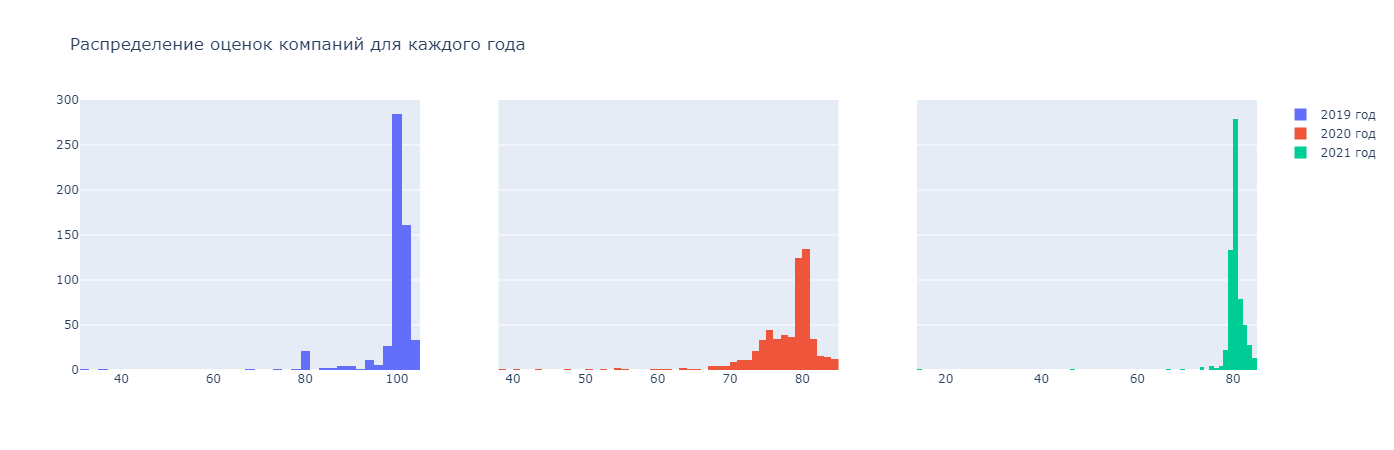

In [31]:
fig = make_subplots(rows=1, cols=3, shared_yaxes=True)

fig.append_trace(go.Histogram(x=rate_2019['points'], name='2019 год'), 1, 1)

fig.append_trace(go.Histogram(x=rate_2020['points'], name='2020 год'), 1, 2)

fig.append_trace(go.Histogram(x=rate_2021['points'], name='2021 год'), 1, 3)

fig.update_layout(title='Распределение оценок компаний для каждого года',
                  coloraxis=dict(colorscale='Bluered_r'),
                  showlegend=True)
fig.show()

display(Image(filename='img/rating_distribution.png', width=800))

In [32]:
def compare_test(groupA, groupB):
    '''
    Функция производит сравнение двух групп.
    1) Проверяется нормальность распределения каждой группы. Если обе группы распределены нормально, для сравнения используется Ttest, в противном случае используется критерий Манна-Уитни.
    2) Если группы рачпределены нормально, проверяется также гипотеза о гомогенности дисперсий двух групп.
    '''
    # Средние и медианы
    print(f'1 группа - среднее: {np.mean(groupA)}, медиана: {np.median(groupA)}')
    print(f'2 группа - среднее: {np.mean(groupB)}, медиана: {np.median(groupB)}')
    print('\n', '#########################################', '\n')
    
    # Проверка данных на нормальность распределения
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Нормальное распределение
    # H1: Не нормальное распределение
    
    if (ntA == False) & (ntB == False): # H0: Нормальное распределение
        # Параметрический тест
        # Проверка гомогенности дисперсий
        print('Обе группы имеют нормальное распределение, используется T-test', '\n')
        print(f'p-value критерия Шапиро-Уилка для первой группы: {shapiro(groupA)[1]}')
        print(f'p-value критерия Шапиро-Уилка для второй группы: {shapiro(groupB)[1]}')
        print('\n', '#########################################', '\n')
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Дисперсии гомогенны
        # H1: Дисперсии гетерогенны
        
        if leveneTest == False:
            # Дисперсии гомогенны, equal_var=True
            print('Дисперсии групп гомогенны', '\n')
            print(f'p-value теста Левена: {stats.levene(groupA, groupB)[1]}')
            print('\n', '#########################################', '\n')
            test_result = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: Средние равны
            # H1: Средние не равны
        else:
            # Дисперсии гетерогенны, equal_var=False
            print('Дисперсии групп гетерогенны', '\n')
            print(f'p-value теста Левена: {stats.levene(groupA, groupB)[1]}')
            print('\n', '#########################################', '\n')
            test_result = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: Средние равны
            # H1: Средние не равны
    else: # H1: Не нормальное распределение
        # Непараметрический тест
        print('Какая-то из групп (либо обе группы) имеет не нормальное распределение, используется критерий Манна-Уитни', '\n')
        print(f'p-value критерия Шапиро-Уилка для первой группы: {shapiro(groupA)[1]}')
        print(f'p-value критерия Шапиро-Уилка для второй группы: {shapiro(groupB)[1]}')
        print('\n', '#########################################', '\n')
        test_result = stats.mannwhitneyu(groupA, groupB)[1]
        # H0: Средние равны
        # H1: Средние не равны
    
    # Print Hypothesis
    print('Тестируемые гипотезы', '\n')
    print('H0: Группы принадлежат одному распределению, различия НЕ ЗНАЧИМЫ')
    print('H1: Группы принадлежат разным распределениям, различия ЗНАЧИМЫ')
    print('\n', '#########################################', '\n')

    if test_result < 0.05:
        print('Есть основания отклонить нулевую гипотезу, различия между группами значимы')
        print(f'Полученное значение p-value: {test_result}')
    else:
        print('Нет оснований отклонить нулевую гипотезу, различия между группами не значимы')
        print(f'Полученное значение p-value: {test_result}')

In [33]:
# Сравнение оценок в 2019 и 2020
compare_test(rate_2019['points'], rate_2020['points'])

1 группа - среднее: 99.15110320284697, медиана: 100.43
2 группа - среднее: 77.66434710743802, медиана: 79.51

 ######################################### 

Какая-то из групп (либо обе группы) имеет не нормальное распределение, используется критерий Манна-Уитни 

p-value критерия Шапиро-Уилка для первой группы: 3.822173844020971e-38
p-value критерия Шапиро-Уилка для второй группы: 5.834929673159698e-31

 ######################################### 

Тестируемые гипотезы 

H0: Группы принадлежат одному распределению, различия НЕ ЗНАЧИМЫ
H1: Группы принадлежат разным распределениям, различия ЗНАЧИМЫ

 ######################################### 

Есть основания отклонить нулевую гипотезу, различия между группами значимы
Полученное значение p-value: 2.8396651559288137e-177


In [34]:
# Сравнение оценок в 2020 и 2021
compare_test(rate_2020['points'], rate_2021['points'])

1 группа - среднее: 77.66434710743802, медиана: 79.51
2 группа - среднее: 80.38958199356914, медиана: 80.4

 ######################################### 

Какая-то из групп (либо обе группы) имеет не нормальное распределение, используется критерий Манна-Уитни 

p-value критерия Шапиро-Уилка для первой группы: 5.834929673159698e-31
p-value критерия Шапиро-Уилка для второй группы: 8.758115402030107e-43

 ######################################### 

Тестируемые гипотезы 

H0: Группы принадлежат одному распределению, различия НЕ ЗНАЧИМЫ
H1: Группы принадлежат разным распределениям, различия ЗНАЧИМЫ

 ######################################### 

Есть основания отклонить нулевую гипотезу, различия между группами значимы
Полученное значение p-value: 1.1307682922647809e-46


In [35]:
# Сравнение оценок в 2019 и 2021
compare_test(rate_2019['points'], rate_2021['points'])

1 группа - среднее: 99.15110320284697, медиана: 100.43
2 группа - среднее: 80.38958199356914, медиана: 80.4

 ######################################### 

Какая-то из групп (либо обе группы) имеет не нормальное распределение, используется критерий Манна-Уитни 

p-value критерия Шапиро-Уилка для первой группы: 3.822173844020971e-38
p-value критерия Шапиро-Уилка для второй группы: 8.758115402030107e-43

 ######################################### 

Тестируемые гипотезы 

H0: Группы принадлежат одному распределению, различия НЕ ЗНАЧИМЫ
H1: Группы принадлежат разным распределениям, различия ЗНАЧИМЫ

 ######################################### 

Есть основания отклонить нулевую гипотезу, различия между группами значимы
Полученное значение p-value: 5.662891214952993e-170


## 2.4. Как менялись оценки 10 самых крупных компаний?

Найдем названия 10 самых крупных компаний.

In [36]:
top_companies_in_2021 = top_companies['company_2021']
top_companies_in_2021

0                                        «ПИК-КОМФОРТ»
1                             «ЖИЛИЩНИК РАЙОНА ПЕРОВО»
2                       «ЖИЛИЩНИК ПРЕСНЕНСКОГО РАЙОНА»
3                         «ЖИЛИЩНИК БАСМАННОГО РАЙОНА»
4    «ЖИЛИЩНИК ЗЕЛЕНОГРАДСКОГО АДМИНИСТРАТИВНОГО ОК...
5                           «ЖИЛИЩНИК РАЙОНА ТВЕРСКОЙ»
6                  «ЖИЛИЩНИК РАЙОНА ХОРОШЕВО-МНЕВНИКИ»
7                            «ЖИЛИЩНИК РАЙОНА ЛЮБЛИНО»
8                         «ЖИЛИЩНИК МОЖАЙСКОГО РАЙОНА»
9                       «ЖИЛИЩНИК РАЙОНА ЮЖНОЕ БУТОВО»
Name: company_2021, dtype: object

Из рейтингов по каждому году соберем значения уровня удовлетворенности населения, уровня надежности УО и уровня нарушений в работе УО.

В 2019 году не собиралась статистика по компании «ЖИЛИЩНИК ЗЕЛЕНОГРАДСКОГО АДМИНИСТРАТИВНОГО ОКРУГА», поэтому соответствующие значения заполним нулями.

In [37]:
rates_for_top_companies_2019 = rate_2019[rate_2019['company'].isin(top_companies_in_2021)] \
                                        [['company', 'satisfaction_level', 'reliability_level', 'violations_level', 'points']]

rates_for_top_companies_2019.loc[len(rates_for_top_companies_2019.index)] = ['«ЖИЛИЩНИК ЗЕЛЕНОГРАДСКОГО АДМИНИСТРАТИВНОГО ОКРУГА»', 0, 0, 0, 0]

rates_for_top_companies_2019 = rates_for_top_companies_2019.sort_values(by='company')

rates_for_top_companies_2019

,company,satisfaction_level,reliability_level,violations_level,points
49,«ЖИЛИЩНИК БАСМАННОГО РАЙОНА»,107.50,99.45,99.57,102.72
9,«ЖИЛИЩНИК ЗЕЛЕНОГРАДСКОГО АДМИНИСТРАТИВНОГО ОК...,0.00,0.00,0.00,0.00
115,«ЖИЛИЩНИК МОЖАЙСКОГО РАЙОНА»,103.95,99.95,99.37,101.32
46,«ЖИЛИЩНИК ПРЕСНЕНСКОГО РАЙОНА»,107.49,99.95,99.41,102.75
424,«ЖИЛИЩНИК РАЙОНА ЛЮБЛИНО»,101.45,98.00,99.66,100.00
134,«ЖИЛИЩНИК РАЙОНА ПЕРОВО»,105.00,98.40,99.50,101.50
158,«ЖИЛИЩНИК РАЙОНА ТВЕРСКОЙ»,107.25,100.00,99.26,102.60
61,«ЖИЛИЩНИК РАЙОНА ХОРОШЕВО-МНЕВНИКИ»,104.85,100.00,99.44,101.72
242,«ЖИЛИЩНИК РАЙОНА ЮЖНОЕ БУТОВО»,99.65,100.00,99.64,99.72
407,«ПИК-КОМФОРТ»,101.00,99.90,99.84,100.33


In [38]:
rates_for_top_companies_2020 = rate_2020[rate_2020['company'].isin(top_companies_in_2021)] \
                                        [['company', 'satisfaction_level', 'reliability_level', 'violations_level', 'points']] \
                                        .sort_values(by='company')

rates_for_top_companies_2020

,company,satisfaction_level,reliability_level,violations_level,points
433,«ЖИЛИЩНИК БАСМАННОГО РАЙОНА»,94.84,0.0,95.97,76.32
328,«ЖИЛИЩНИК ЗЕЛЕНОГРАДСКОГО АДМИНИСТРАТИВНОГО ОК...,100.40,0.0,97.42,79.13
462,«ЖИЛИЩНИК МОЖАЙСКОГО РАЙОНА»,92.98,0.0,96.15,75.65
359,«ЖИЛИЩНИК ПРЕСНЕНСКОГО РАЙОНА»,99.46,80.0,96.26,78.45
556,«ЖИЛИЩНИК РАЙОНА ЛЮБЛИНО»,82.87,50.0,96.28,71.76
427,«ЖИЛИЩНИК РАЙОНА ПЕРОВО»,93.55,0.0,97.62,76.47
441,«ЖИЛИЩНИК РАЙОНА ТВЕРСКОЙ»,96.33,0.0,94.10,76.17
461,«ЖИЛИЩНИК РАЙОНА ХОРОШЕВО-МНЕВНИКИ»,92.00,89.0,96.58,75.65
426,«ЖИЛИЩНИК РАЙОНА ЮЖНОЕ БУТОВО»,93.18,0.0,98.00,76.47
375,«ПИК-КОМФОРТ»,96.41,0.0,98.47,77.95


In [39]:
rates_for_top_companies_2021 = rate_2021[rate_2021['company'].isin(top_companies_in_2021)] \
                                        [['company', 'satisfaction_level', 'reliability_level', 'violations_level', 'points']] \
                                        .sort_values(by='company')

rates_for_top_companies_2021

,company,satisfaction_level,reliability_level,violations_level,points
114,«ЖИЛИЩНИК БАСМАННОГО РАЙОНА»,106.41,50.0,97.48,81.65
242,«ЖИЛИЩНИК ЗЕЛЕНОГРАДСКОГО АДМИНИСТРАТИВНОГО ОК...,102.61,50.0,99.00,80.77
133,«ЖИЛИЩНИК МОЖАЙСКОГО РАЙОНА»,104.79,50.0,98.58,81.45
92,«ЖИЛИЩНИК ПРЕСНЕНСКОГО РАЙОНА»,107.40,88.0,97.12,81.98
352,«ЖИЛИЩНИК РАЙОНА ЛЮБЛИНО»,101.43,75.0,98.45,80.10
125,«ЖИЛИЩНИК РАЙОНА ПЕРОВО»,105.00,50.0,98.55,81.55
96,«ЖИЛИЩНИК РАЙОНА ТВЕРСКОЙ»,107.00,50.0,97.52,81.94
124,«ЖИЛИЩНИК РАЙОНА ХОРОШЕВО-МНЕВНИКИ»,104.90,94.0,98.50,81.55
500,«ЖИЛИЩНИК РАЙОНА ЮЖНОЕ БУТОВО»,100.13,50.0,99.17,79.82
350,«ПИК-КОМФОРТ»,100.71,48.0,99.33,80.11


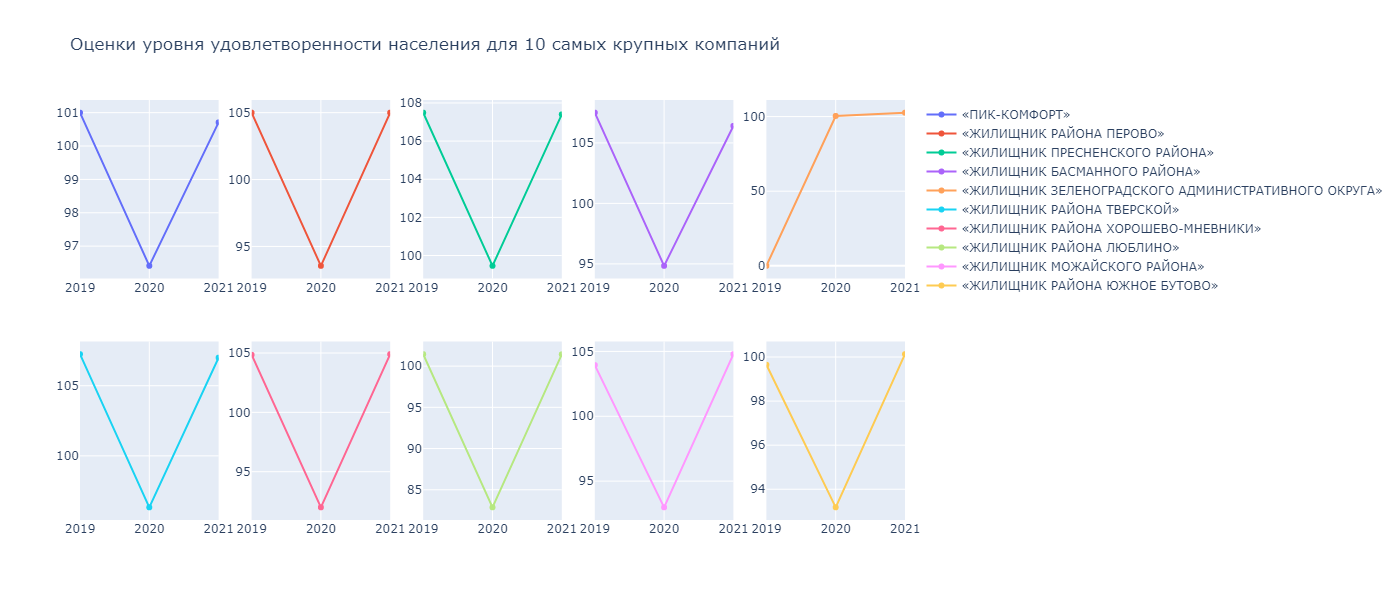

In [40]:
years = [2019, 2020, 2021]

row=1
col=1

fig = make_subplots(rows=2, cols=5)

for company in top_companies_in_2021:
    fig.add_trace(
        go.Scatter(x=years,
                   y=[rates_for_top_companies_2019[rates_for_top_companies_2019['company'] == company]['satisfaction_level'].iloc[0],
                      rates_for_top_companies_2020[rates_for_top_companies_2020['company'] == company]['satisfaction_level'].iloc[0],
                      rates_for_top_companies_2021[rates_for_top_companies_2021['company'] == company]['satisfaction_level'].iloc[0]],
                   name=company),
        row=row, col=col
    )

    if col == 5:
        row+=1
        col=0

    col+=1

fig.update_xaxes(range=[2019, 2021], dtick=1)

fig.update_layout(
    height=600, 
    width=1400, 
    title_text='Оценки уровня удовлетворенности населения для 10 самых крупных компаний'
)

fig.show()

display(Image(filename='img/satisfaction_lvl.png', width=800))

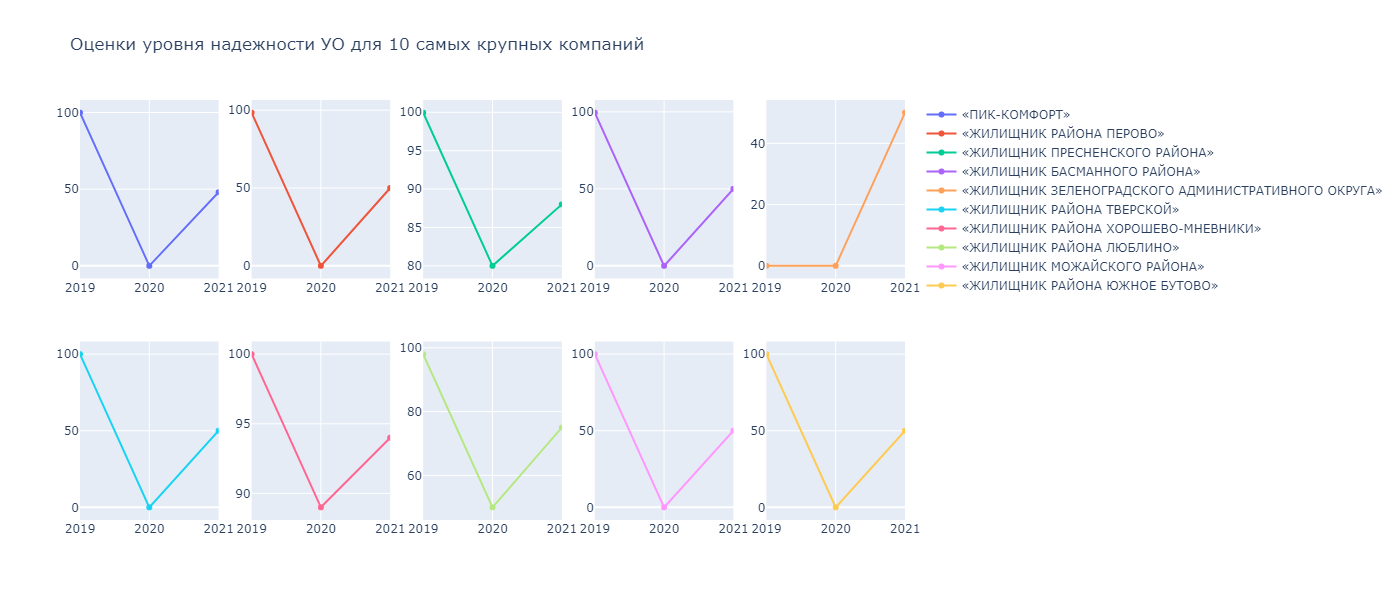

In [41]:
years = [2019, 2020, 2021]

row=1
col=1

fig = make_subplots(rows=2, cols=5)

for company in top_companies_in_2021:
    fig.add_trace(
        go.Scatter(x=years,
                   y=[rates_for_top_companies_2019[rates_for_top_companies_2019['company'] == company]['reliability_level'].iloc[0],
                      rates_for_top_companies_2020[rates_for_top_companies_2020['company'] == company]['reliability_level'].iloc[0],
                      rates_for_top_companies_2021[rates_for_top_companies_2021['company'] == company]['reliability_level'].iloc[0]],
                   name=company),
        row=row, col=col
    )

    if col == 5:
        row+=1
        col=0

    col+=1

fig.update_xaxes(range=[2019, 2021], dtick=1)

fig.update_layout(
    height=600, 
    width=1400, 
    title_text='Оценки уровня надежности УО для 10 самых крупных компаний'
)

fig.show()

display(Image(filename='img/reliability_lvl.png', width=800))

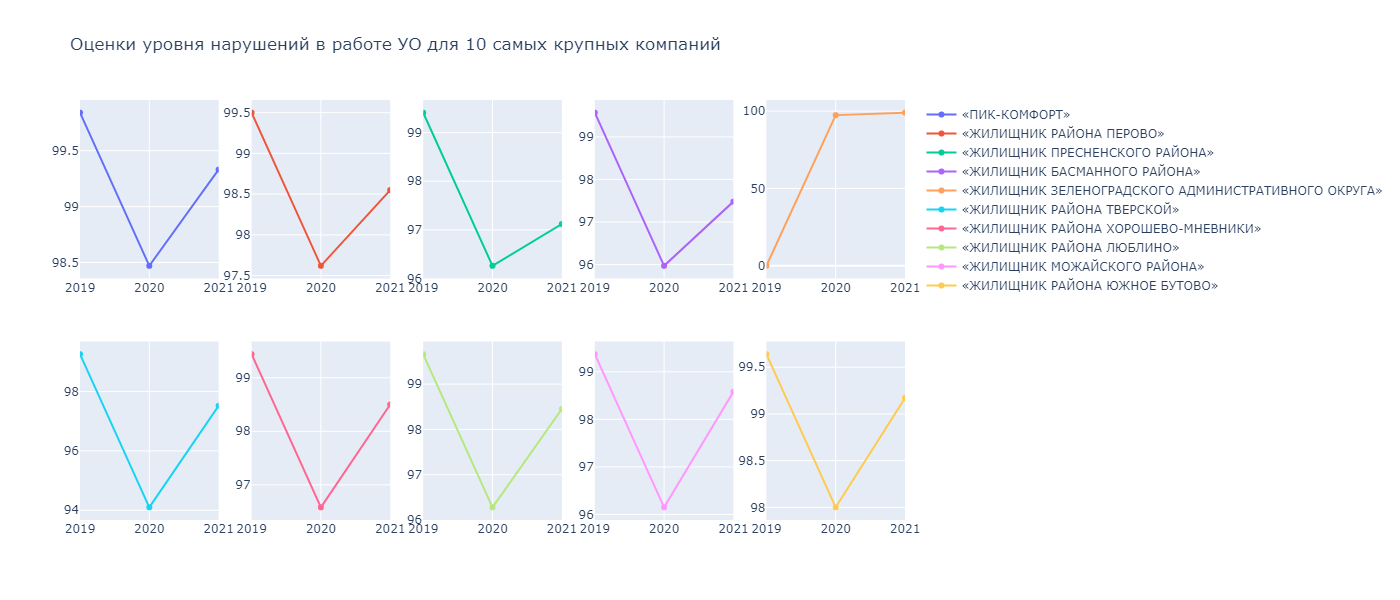

In [42]:
years = [2019, 2020, 2021]

row=1
col=1

fig = make_subplots(rows=2, cols=5)

for company in top_companies_in_2021:
    fig.add_trace(
        go.Scatter(x=years,
                   y=[rates_for_top_companies_2019[rates_for_top_companies_2019['company'] == company]['violations_level'].iloc[0],
                      rates_for_top_companies_2020[rates_for_top_companies_2020['company'] == company]['violations_level'].iloc[0],
                      rates_for_top_companies_2021[rates_for_top_companies_2021['company'] == company]['violations_level'].iloc[0]],
                   name=company),
        row=row, col=col
    )

    if col == 5:
        row+=1
        col=0

    col+=1

fig.update_xaxes(range=[2019, 2021], dtick=1)

fig.update_layout(
    height=600, 
    width=1400, 
    title_text='Оценки уровня нарушений в работе УО для 10 самых крупных компаний'
)

fig.show()

display(Image(filename='img/violations_lvl.png', width=800))

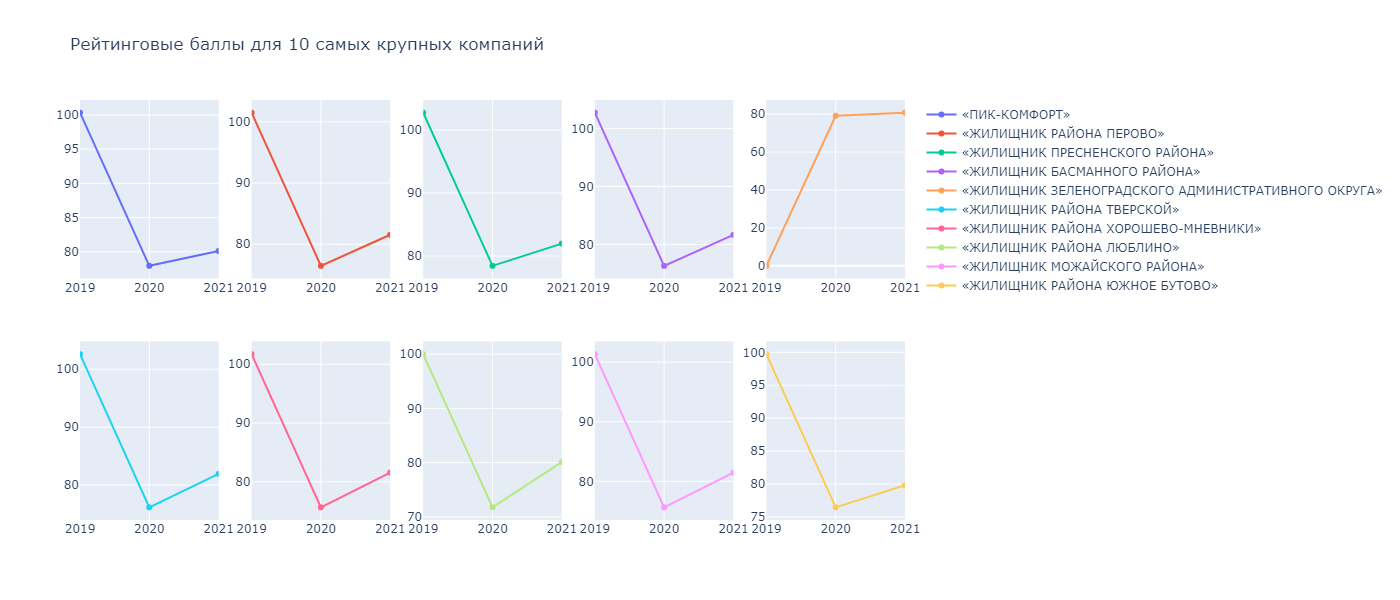

In [43]:
years = [2019, 2020, 2021]

row=1
col=1

fig = make_subplots(rows=2, cols=5)

for company in top_companies_in_2021:
    fig.add_trace(
        go.Scatter(x=years,
                   y=[rates_for_top_companies_2019[rates_for_top_companies_2019['company'] == company]['points'].iloc[0],
                      rates_for_top_companies_2020[rates_for_top_companies_2020['company'] == company]['points'].iloc[0],
                      rates_for_top_companies_2021[rates_for_top_companies_2021['company'] == company]['points'].iloc[0]],
                   name=company),
        row=row, col=col
    )

    if col == 5:
        row+=1
        col=0

    col+=1

fig.update_xaxes(range=[2019, 2021], dtick=1)

fig.update_layout(
    height=600, 
    width=1400, 
    title_text='Рейтинговые баллы для 10 самых крупных компаний'
)

fig.show()

display(Image(filename='img/rating.png', width=800))

На графиках можно увидеть, что значения по каждому критерию оценки меняются по одинаковому паттерну. В 2019 году значения самые высокие, в 2020 году просадка, затем рост в 2021 году.

Кроме компании «ЖИЛИЩНИК ЗЕЛЕНОГРАДСКОГО АДМИНИСТРАТИВНОГО ОКРУГА». Для данной компании отсутствуют данные по 2019 году, а в 2020 и 2021 оценки примерно одинаковы.

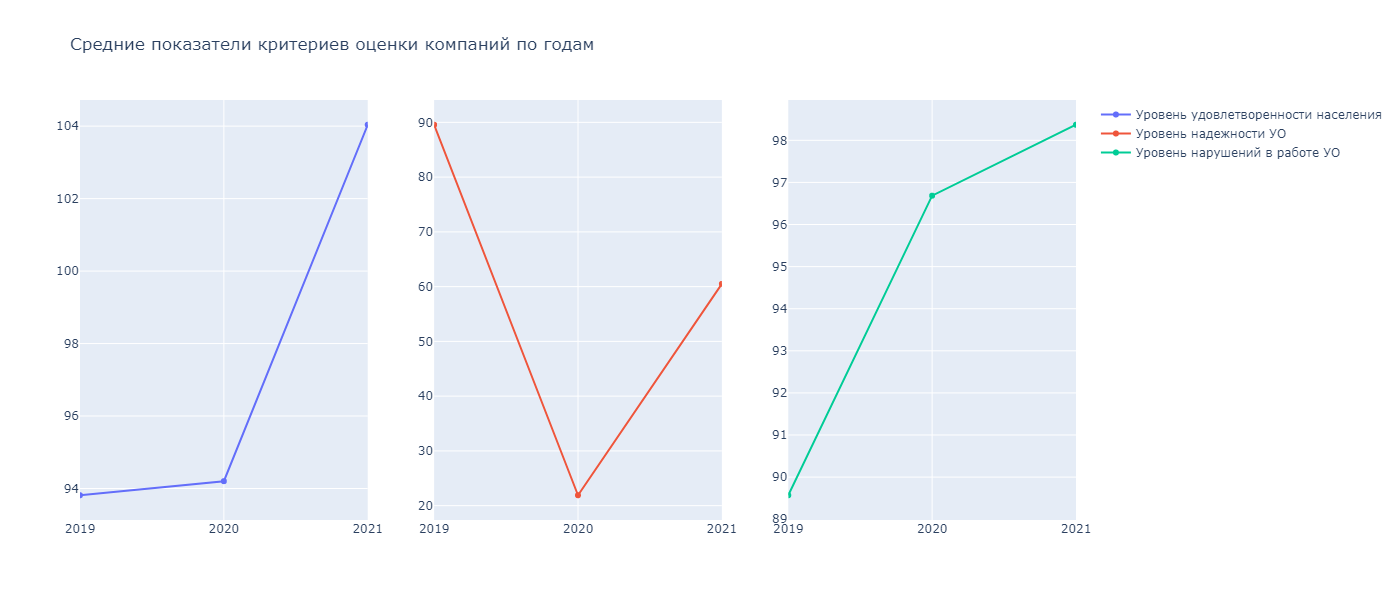

In [44]:
years = [2019, 2020, 2021]

row=1
col=1

fig = make_subplots(rows=1, cols=3)

fig.add_trace(
        go.Scatter(x=years,
                   y=[np.mean(rates_for_top_companies_2019['satisfaction_level']),
                      np.mean(rates_for_top_companies_2020['satisfaction_level']),
                      np.mean(rates_for_top_companies_2021['satisfaction_level'])],
                   name='Уровень удовлетворенности населения'),
        row=1, col=1
)

fig.add_trace(
        go.Scatter(x=years,
                   y=[np.mean(rates_for_top_companies_2019['reliability_level']),
                      np.mean(rates_for_top_companies_2020['reliability_level']),
                      np.mean(rates_for_top_companies_2021['reliability_level'])],
                   name='Уровень надежности УО'),
        row=1, col=2
)

fig.add_trace(
        go.Scatter(x=years,
                   y=[np.mean(rates_for_top_companies_2019['violations_level']),
                      np.mean(rates_for_top_companies_2020['violations_level']),
                      np.mean(rates_for_top_companies_2021['violations_level'])],
                   name='Уровень нарушений в работе УО'),
        row=1, col=3
)

fig.update_xaxes(range=[2019, 2021], dtick=1)

fig.update_layout(
    height=600, 
    width=1400, 
    title_text='Средние показатели критериев оценки компаний по годам'
)

fig.show()

display(Image(filename='img/avg_rating.png', width=800))

Можно видеть, что средний уровень удовлетворенности населения по всем компаниям растет, в то же время для крупных компаний наблюдаются высокие значения в 2019 и 2021 годах, в 2020 году наблюдается просадка.

Средний уровень надежности УО по всем компаниям не отличается от уровня надежности для крупных компаний.

Средняя оценка уровня нарушений по всем компаниям растет, для крупных компаний - наибольшие значения в 2019 и 2021, просадка в 2019.

# Выводы

### 1. В каких административных округах находится наибольшее количество компаний? Происходят ли изменения от года к году?

Самые крупные административные округа - Центральный, Новомосковский, Троицкий, Северный, Западный, Восточный. Сильных изменений в лидерах не наблюдается.

### 2. Какие компании являются самыми крупными? В каких округах они ведут работу?

Наиболее крупные компании - «ПИК-КОМФОРТ», «ЖИЛИЩНИК ПРЕСНЕНСКОГО РАЙОНА», «ЖИЛИЩНИК РАЙОНА ПЕРОВО», «ЖИЛИЩНИК БАСМАННОГО РАЙОНА», «ЖИЛИЩНИК ЗЕЛЕНОГРАДСКОГО АДМИНИСТРАТИВНОГО ОКРУГА». Самый часто встречающийся округ среди крупных компаний - Центральный. Есть компания, работающая сразу в нескольких округах - это «ПИК-КОМФОРТ».

### 3. Являются ли изменения в оценках компаний статистически значимыми?

Распределения оценок не являются нормальными, для сравнения групп между собой используется критерий Манна-Уитни.

2019 и 2020 - различия значимы.

2020 и 2021 - различия значимы.

2019 и 2021 - различия значимы.

### 4. Как менялись оценки 10 самых крупных компаний?

По всем трем критериям оценки компаний наибольшие значения наблюдаются в 2019 и 2021 годах, а в 2020 наблюдается спад. При этом средние значения оценок по всем компаниям в некоторых случаях имеют отличающееся распределение.